## CA04 – Ensemble Models

This notebook completes CA04 using the same Census dataset as CA03 and reuses the same cleaning/encoding pipeline.

Models
- Random Forest
- AdaBoost
- Gradient Boosting
- XGBoost (if available)

Task
For each model, plot:
- Accuracy vs. n_estimators
- AUC vs. n_estimators

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score

#Reproducibility
RANDOM_STATE = 101

In [2]:
#Load data
df = pd.read_csv("https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true")
#Preview
df.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0


In [3]:
#Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  48842 non-null  object
 1   occupation_bin      48842 non-null  object
 2   msr_bin             48842 non-null  object
 3   capital_gl_bin      48842 non-null  object
 4   race_sex_bin        48842 non-null  object
 5   education_num_bin   48842 non-null  object
 6   education_bin       48842 non-null  object
 7   workclass_bin       48842 non-null  object
 8   age_bin             48842 non-null  object
 9   flag                48842 non-null  object
 10  y                   48842 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.1+ MB


In [4]:
#Missing values
df.isna().sum()

hours_per_week_bin    0
occupation_bin        0
msr_bin               0
capital_gl_bin        0
race_sex_bin          0
education_num_bin     0
education_bin         0
workclass_bin         0
age_bin               0
flag                  0
y                     0
dtype: int64

In [5]:
#Duplicate values
df.duplicated().sum()

np.int64(40012)

In [6]:
#Descriptive statistics
df.describe(include="all")

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842.000000
unique,5,5,3,3,3,5,5,2,5,2,NaN
top,b. 31-40,c. Mid - Mid,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,NaN
freq,26639,13971,22047,42525,29737,30324,30324,46012,13963,32561,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.239282
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.426649
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [7]:
#Identify columns 
TARGET_COL = "y" #0/1 label
SPLIT_COL  = "flag" #Training/testing indicator

#Verify values
print("Target value counts:")
print(df[TARGET_COL].value_counts(dropna=False))
print("\nSplit values:")
print(df[SPLIT_COL].value_counts(dropna=False))

Target value counts:
y
0    37155
1    11687
Name: count, dtype: int64

Split values:
flag
train    32561
test     16281
Name: count, dtype: int64


In [8]:
#Split training vs testing
flag_lower = df[SPLIT_COL].astype(str).str.lower()

train_df = df[flag_lower.str.contains("train")].copy()
test_df  = df[flag_lower.str.contains("test")].copy()

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (32561, 11)
Test shape: (16281, 11)


In [9]:
#One-hot encode features
X_train = pd.get_dummies(train_df.drop([TARGET_COL, SPLIT_COL], axis=1))
y_train = train_df[TARGET_COL].astype(int)

X_test  = pd.get_dummies(test_df.drop([TARGET_COL, SPLIT_COL], axis=1))
y_test  = test_df[TARGET_COL].astype(int)

#Make test columns match training columns
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print("X_train:", X_train.shape, "X_test:", X_test.shape)

X_train: (32561, 36) X_test: (16281, 36)


In [10]:
#XGBoost compatibility fix 
#XGBoost requires feature names to be strings and not contain special characters like [, ], or <
X_train.columns = (X_train.columns.astype(str)
                   .str.replace('[', '', regex=False)
                   .str.replace(']', '', regex=False)
                   .str.replace('<', '', regex=False))

X_test.columns = (X_test.columns.astype(str)
                  .str.replace('[', '', regex=False)
                  .str.replace(']', '', regex=False)
                  .str.replace('<', '', regex=False))

print("Sanitized feature names for XGBoost.")

Sanitized feature names for XGBoost.


In [11]:
#Helper functions
#These functions avoid repeating the same training + evaluation loop for each model.

def eval_over_n_estimators(make_model_fn, n_values, X_train, y_train, X_test, y_test):

    acc_list, auc_list = [], []

    for n in n_values:
        # 1) Build model for this n_estimators value
        model = make_model_fn(n)

        # 2) Fit model on training data
        model.fit(X_train, y_train)

        # 3) Predict class labels (used for Accuracy)
        y_pred = model.predict(X_test)

        # 4) Predict probabilities for AUC calculation
        #    AUC requires probability scores for the positive class
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)[:, 1]
        else:
            # Fallback for models without predict_proba
            scores = model.decision_function(X_test)
            y_prob = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)

        # 5) Store Accuracy and AUC
        acc_list.append(accuracy_score(y_test, y_pred))
        auc_list.append(roc_auc_score(y_test, y_prob))

    return acc_list, auc_list


#Line plot function for metric vs n_estimators
def plot_metric(n_values, values, title, y_label):
    plt.figure(figsize=(8, 4))
    plt.plot(n_values, values, marker="o")
    plt.title(title)
    plt.xlabel("n_estimators")
    plt.ylabel(y_label)
    plt.grid(True, alpha=0.3)
    plt.show()

#Required n_estimators values (per assignment instructions)
n_values = [50,100,150,200,250,300,350,400,450,500]

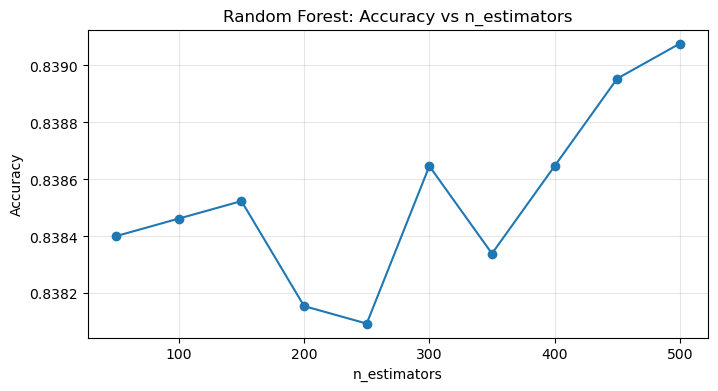

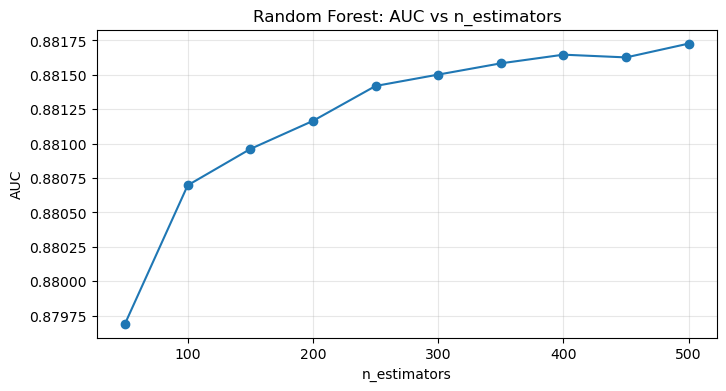

Best RF Accuracy: 0.8390762238191757 at n = 500
Best RF AUC: 0.8817262766907942 at n = 500


In [12]:
#Random Forest

from sklearn.ensemble import RandomForestClassifier

def make_rf(n):
    # Keep other hyperparameters at default (per assignment); only vary n_estimators
    return RandomForestClassifier(n_estimators=n, random_state=RANDOM_STATE)

rf_acc, rf_auc = eval_over_n_estimators(make_rf, n_values, X_train, y_train, X_test, y_test)

#Plots required by the assignment
plot_metric(n_values, rf_acc, "Random Forest: Accuracy vs n_estimators", "Accuracy")
plot_metric(n_values, rf_auc, "Random Forest: AUC vs n_estimators", "AUC")

#Print the best n within the given range
print("Best RF Accuracy:", max(rf_acc), "at n =", n_values[int(np.argmax(rf_acc))])
print("Best RF AUC:", max(rf_auc), "at n =", n_values[int(np.argmax(rf_auc))])

### Observations

**Behavior as n_estimators increases:**  
As n_estimators increases, both Accuracy and AUC show a gradual upward trend with minor fluctuations. The model becomes more stable as more trees are added, leading to small but consistent improvements in performance. The AUC curve increases steadily and begins to level off at higher estimator values.

**Is there an optimal value within the given range?**  
Yes. The optimal value appears toward the higher end of the tested range (around 500), where AUC reaches its maximum and the curve begins to plateau. Beyond this point, additional estimators provide minimal performance gain.

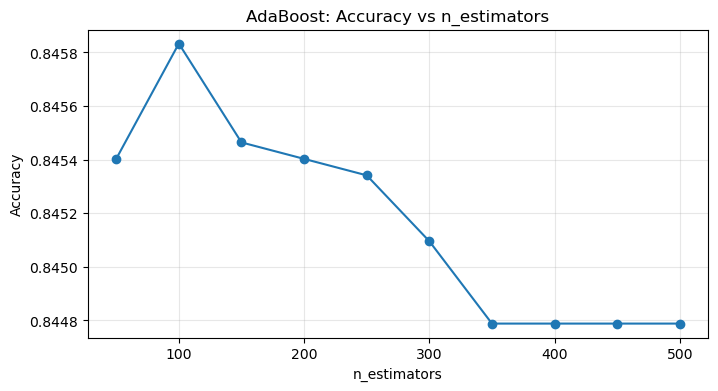

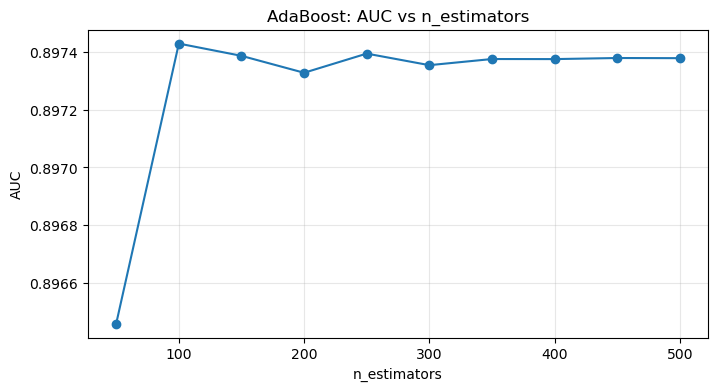

Best Ada Accuracy: 0.8458325655672256 at n = 100
Best Ada AUC: 0.8974291380179534 at n = 100


In [13]:
#AdaBoost

from sklearn.ensemble import AdaBoostClassifier

def make_ada(n):
    return AdaBoostClassifier(n_estimators=n, random_state=RANDOM_STATE)

ada_acc, ada_auc = eval_over_n_estimators(make_ada, n_values, X_train, y_train, X_test, y_test)

plot_metric(n_values, ada_acc, "AdaBoost: Accuracy vs n_estimators", "Accuracy")
plot_metric(n_values, ada_auc, "AdaBoost: AUC vs n_estimators", "AUC")

print("Best Ada Accuracy:", max(ada_acc), "at n =", n_values[int(np.argmax(ada_acc))])
print("Best Ada AUC:", max(ada_auc), "at n =", n_values[int(np.argmax(ada_auc))])

### Observations

**Behavior as n_estimators increases:**  
Accuracy peaks early (around 100 estimators) and then gradually declines slightly as more estimators are added. AUC shows a sharp improvement at lower estimator values and then remains relatively stable with small fluctuations.

**Is there an optimal value within the given range?**  
Yes. The optimal value occurs at lower estimator values (around 100), where both Accuracy and AUC are highest. Increasing n_estimators beyond this point does not improve performance and may slightly reduce Accuracy.

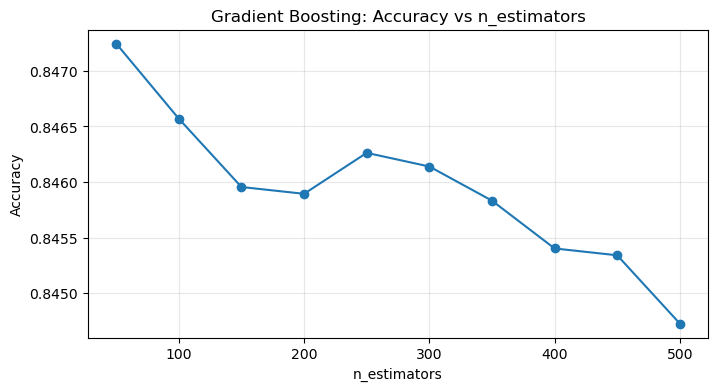

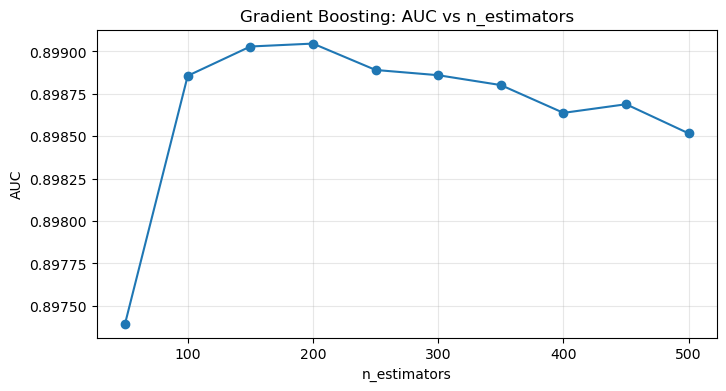

Best GB Accuracy: 0.8472452552054542 at n = 50
Best GB AUC: 0.8990456248728438 at n = 200


In [14]:
#Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier

def make_gb(n):
    return GradientBoostingClassifier(n_estimators=n, random_state=RANDOM_STATE)

gb_acc, gb_auc = eval_over_n_estimators(make_gb, n_values, X_train, y_train, X_test, y_test)

plot_metric(n_values, gb_acc, "Gradient Boosting: Accuracy vs n_estimators", "Accuracy")
plot_metric(n_values, gb_auc, "Gradient Boosting: AUC vs n_estimators", "AUC")

print("Best GB Accuracy:", max(gb_acc), "at n =", n_values[int(np.argmax(gb_acc))])
print("Best GB AUC:", max(gb_auc), "at n =", n_values[int(np.argmax(gb_auc))])

### Observations

**Behavior as n_estimators increases:**  
Accuracy is highest at lower estimator values and gradually declines as n_estimators increases. AUC improves initially and peaks around 200 estimators before slightly decreasing afterward. This suggests that additional estimators may begin to introduce overfitting.

**Is there an optimal value within the given range?**  
Yes. The optimal value appears in the lower-to-mid range (approximately 200), where AUC reaches its maximum. Beyond this range, performance slightly declines.

/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [13:38:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [13:38:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [13:38:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.13/site-packages/xgboost/training.py:200: UserWarning: [13:38:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

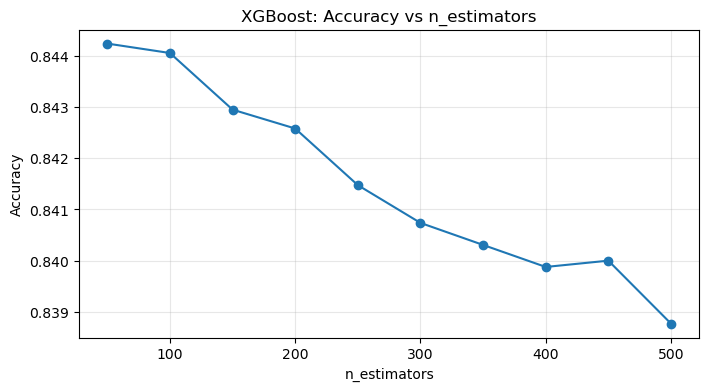

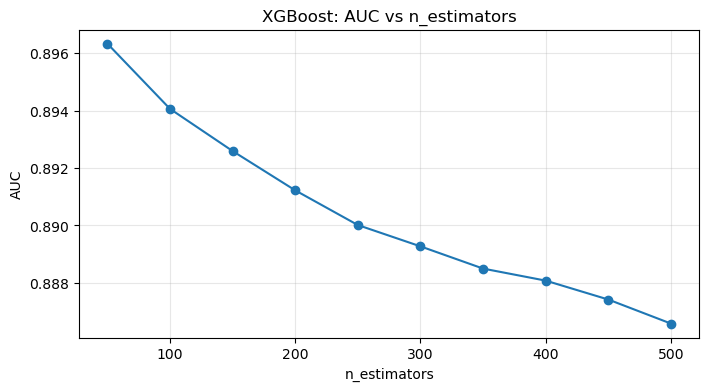

Best XGB Accuracy: 0.8442356120631411 at n = 50
Best XGB AUC: 0.8963341983619032 at n = 50


In [15]:
#XGBoost

try:
    from xgboost import XGBClassifier

    def make_xgb(n):
        return XGBClassifier(
            n_estimators=n,
            random_state=RANDOM_STATE,
            eval_metric="logloss",
            use_label_encoder=False)

    xgb_acc, xgb_auc = eval_over_n_estimators(make_xgb, n_values, X_train, y_train, X_test, y_test)

    plot_metric(n_values, xgb_acc, "XGBoost: Accuracy vs n_estimators", "Accuracy")
    plot_metric(n_values, xgb_auc, "XGBoost: AUC vs n_estimators", "AUC")

    print("Best XGB Accuracy:", max(xgb_acc), "at n =", n_values[int(np.argmax(xgb_acc))])
    print("Best XGB AUC:", max(xgb_auc), "at n =", n_values[int(np.argmax(xgb_auc))])

except Exception as e:
    print("XGBoost section skipped:", e)
    xgb_acc, xgb_auc = None, None

### Observations

**Behavior as n_estimators increases:**  
Both Accuracy and AUC are highest at the smallest estimator value (50) and steadily decline as n_estimators increases. This indicates that increasing the number of estimators does not improve performance for this configuration and may lead to overfitting.

**Is there an optimal value within the given range?**  
Yes. The optimal value is at the lower end of the range (50 estimators), where the model achieves its highest Accuracy and AUC. Increasing estimators beyond this point results in decreasing performance.

In [16]:
#Comparing results (best Accuracy & best AUC for each model)

rows = []
rows.append(("Random Forest", max(rf_acc), max(rf_auc)))
rows.append(("AdaBoost", max(ada_acc), max(ada_auc)))
rows.append(("Gradient Boosting", max(gb_acc), max(gb_auc)))

if xgb_acc is not None and xgb_auc is not None:
    rows.append(("XGBoost", max(xgb_acc), max(xgb_auc)))
else:
    rows.append(("XGBoost", np.nan, np.nan))

results = pd.DataFrame(rows, columns=["Model", "Best Accuracy", "Best AUC"])
results

,Model,Best Accuracy,Best AUC
0,Random Forest,0.839076,0.881726
1,AdaBoost,0.845833,0.897429
2,Gradient Boosting,0.847245,0.899046
3,XGBoost,0.844236,0.896334


## Final Conclusion

Model performance trends varied across the four ensemble methods. Random Forest showed a gradual improvement in both Accuracy and AUC as the number of estimators increased, eventually stabilizing at higher values.

In contrast, AdaBoost, Gradient Boosting, and XGBoost achieved their best performance at lower or mid-range estimator values. For these boosting models, increasing the number of estimators beyond the optimal range did not improve performance and in some cases slightly reduced Accuracy and AUC.

Among all models, Gradient Boosting achieved the highest AUC (0.899046), indicating the strongest ranking performance for predicting income class. Overall, the results demonstrate that increasing n_estimators does not universally improve performance, and each ensemble method has its own optimal estimator range.